In [1]:
import pandas as pd
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names

In [2]:
data = pd.read_csv('./data/criteo_sample.txt')

In [3]:
data.head()

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,NaN,3,260.0,NaN,17668.0,NaN,NaN,33.0,NaN,...,e5ba7672,87c6f83c,NaN,NaN,0429f84b,NaN,3a171ecb,c0d61a5c,NaN,NaN
1,0,NaN,-1,19.0,35.0,30251.0,247.0,1.0,35.0,160.0,...,d4bb7bd8,6fc84bfb,NaN,NaN,5155d8a3,NaN,be7c41b4,ded4aac9,NaN,NaN
2,0,0.0,0,2.0,12.0,2013.0,164.0,6.0,35.0,523.0,...,e5ba7672,675c9258,NaN,NaN,2e01979f,NaN,bcdee96c,6d5d1302,NaN,NaN
3,0,NaN,13,1.0,4.0,16836.0,200.0,5.0,4.0,29.0,...,e5ba7672,52e44668,NaN,NaN,e587c466,NaN,32c7478e,3b183c5c,NaN,NaN
4,0,0.0,0,104.0,27.0,1990.0,142.0,4.0,32.0,37.0,...,e5ba7672,25c88e42,21ddcdc9,b1252a9d,0e8585d2,NaN,32c7478e,0d4a6d1a,001f3601,92c878de


In [4]:
sparse_features = ['C' + str(i) for i in range(1, 27)]
dense_features = ['I' + str(i) for i in range(1, 14)]

In [5]:
data[sparse_features] = data[sparse_features].fillna('-1', )
data[dense_features] = data[dense_features].fillna(0, )
target = ['label']

In [6]:
# Label Encoding for sparse features,and do simple Transformation for dense features
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])
mms = MinMaxScaler(feature_range=(0, 1))
data[dense_features] = mms.fit_transform(data[dense_features])

In [7]:
# Count #unique features for each sparse field,and record dense feature field name
fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].max() + 1, embedding_dim=4)
                            for i, feat in enumerate(sparse_features)] + [DenseFeat(feat, 1, )
                                                                        for feat in dense_features]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [8]:
fixlen_feature_columns

[SparseFeat(name='C1', vocabulary_size=27, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x00000222A2388C08>, embedding_name='C1', group_name='default_group', trainable=True),
 SparseFeat(name='C2', vocabulary_size=92, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x00000222A23F3C88>, embedding_name='C2', group_name='default_group', trainable=True),
 SparseFeat(name='C3', vocabulary_size=172, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x00000222A23F3048>, embedding_name='C3', group_name='default_group', trainable=True),
 SparseFeat(name='C4', vocabulary_size=157, embedding_dim=4, use_hash=False, vocabulary_path=None, 

In [9]:
# Generate input data for model
train, test = train_test_split(data, test_size=0.2, random_state=2020)
train_model_input = {name: train[name] for name in feature_names}
test_model_input = {name: test[name] for name in feature_names}

In [10]:
# Define Model
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='binary')
model.compile("adam", "binary_crossentropy",
                metrics=['binary_crossentropy'], )

In [11]:
# Train Model
history = model.fit(train_model_input, train[target].values,
                        batch_size=256, epochs=20, verbose=2, validation_split=0.2, )

Epoch 1/20
1/1 - 7s - loss: 0.7278 - binary_crossentropy: 0.7278 - val_loss: 0.7395 - val_binary_crossentropy: 0.7395
Epoch 2/20
1/1 - 0s - loss: 0.7055 - binary_crossentropy: 0.7055 - val_loss: 0.7237 - val_binary_crossentropy: 0.7237
Epoch 3/20
1/1 - 0s - loss: 0.6849 - binary_crossentropy: 0.6849 - val_loss: 0.7087 - val_binary_crossentropy: 0.7086
Epoch 4/20
1/1 - 0s - loss: 0.6650 - binary_crossentropy: 0.6650 - val_loss: 0.6938 - val_binary_crossentropy: 0.6938
Epoch 5/20
1/1 - 0s - loss: 0.6451 - binary_crossentropy: 0.6451 - val_loss: 0.6789 - val_binary_crossentropy: 0.6789
Epoch 6/20
1/1 - 0s - loss: 0.6250 - binary_crossentropy: 0.6250 - val_loss: 0.6644 - val_binary_crossentropy: 0.6644
Epoch 7/20
1/1 - 0s - loss: 0.6047 - binary_crossentropy: 0.6047 - val_loss: 0.6502 - val_binary_crossentropy: 0.6502
Epoch 8/20
1/1 - 0s - loss: 0.5843 - binary_crossentropy: 0.5843 - val_loss: 0.6365 - val_binary_crossentropy: 0.6365
Epoch 9/20
1/1 - 0s - loss: 0.5637 - binary_crossentropy

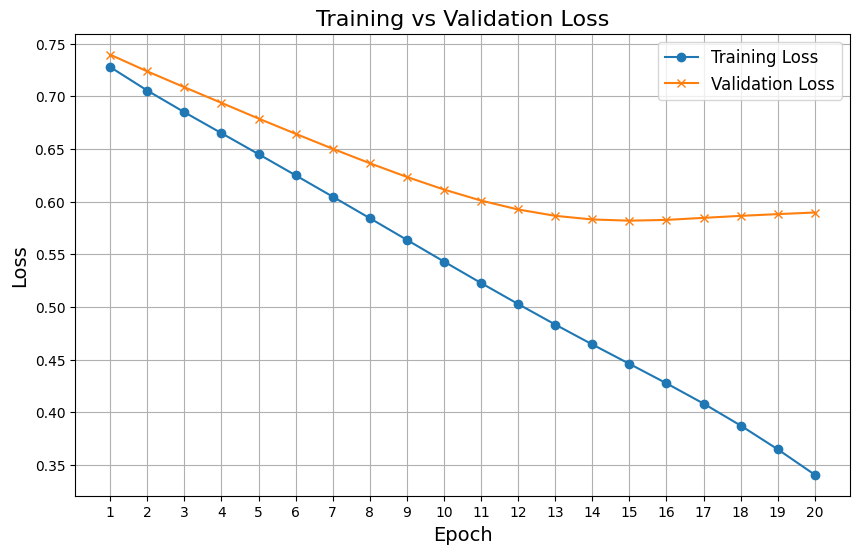

In [12]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='x')

plt.title("Training vs Validation Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(range(len(train_loss)), range(1, len(train_loss) + 1))  # Ensure x-ticks match the epoch numbers

plt.show()


In [13]:
# Predict
pred_ans = model.predict(test_model_input, batch_size=256)

In [14]:
# Evaluate the Model
print("test LogLoss:", round(log_loss(test[target].values, pred_ans), 4))
print("test AUC:", round(roc_auc_score(test[target].values, pred_ans), 4))

test LogLoss: 0.5047
test AUC: 0.6774


### Inference

In [15]:
for feature in feature_names:
    print(feature, end=' ')

C1 C2 C3 C4 C5 C6 C7 C8 C9 C10 C11 C12 C13 C14 C15 C16 C17 C18 C19 C20 C21 C22 C23 C24 C25 C26 I1 I2 I3 I4 I5 I6 I7 I8 I9 I10 I11 I12 I13 

In [16]:
import numpy as np

model_input = {'C1': np.array([8]),
               'C2': np.array([52]),
               'C3': np.array([0]),
               'C4': np.array([0]),
               'C5': np.array([156]),
               'C6': np.array([0]),
               'C7': np.array([50]),
               'C8': np.array([1]),
               'C9': np.array([2]),
               'C10': np.array([39]),
               'C11': np.array([99]),
               'C12': np.array([32]),
               'C13': np.array([56]),
               'C14': np.array([8]),
               'C15': np.array([87]),
               'C16': np.array([34]),
               'C17': np.array([4]),
               'C18': np.array([101]),
               'C19': np.array([43]),
               'C20': np.array([1]),
               'C21': np.array([34]),
               'C22': np.array([34]),
               'C23': np.array([0]),
               'C24': np.array([0]),
               'C25': np.array([5]),
               'C26': np.array([3]),
               'I1': np.array([0.00003]),
               'I2': np.array([0.1379]),
               'I3': np.array([0.0]),
               'I4': np.array([0.11]),
               'I5': np.array([0.00033]),
               'I6': np.array([0.45]),
               'I7': np.array([0.2]),
               'I8': np.array([0.003]),
               'I9': np.array([0.92]),
               'I10': np.array([0.76]),
               'I11': np.array([0.0]),
               'I12': np.array([1.0]),
               'I13': np.array([0.34])
               }

In [17]:
model.predict(model_input)

array([[0.13150133]], dtype=float32)